### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from config.path import PathHelper

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [19]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [2]:
CHECKPOINT_PATH = os.path.join(os.getcwd(), "weights", "sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [3]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [4]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [6]:
path_helper = PathHelper()

file_name = 'tshirt_0006.png'

img_path = path_helper.get_full_cloth_type_path(file_name)
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [18]:
def draw_bounding_box(image, bbox):
    # Extract coordinates from the bounding box
    x1, y1, x2, y2 = bbox
    
    # Draw the bounding box on the image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green color, thickness 2
    
    return image


image_bgr = draw_bounding_box(image_bgr, sam_result[0]['bbox'])

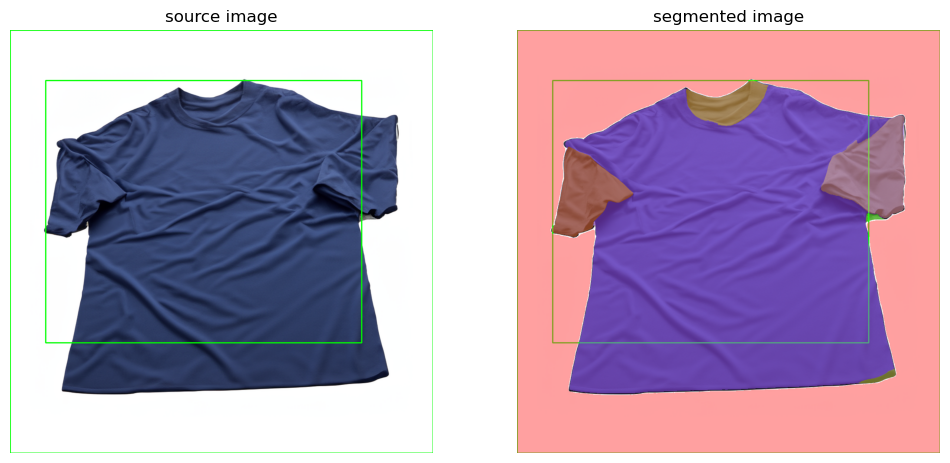

In [19]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

[0.8087599  0.9365331  0.94612086]


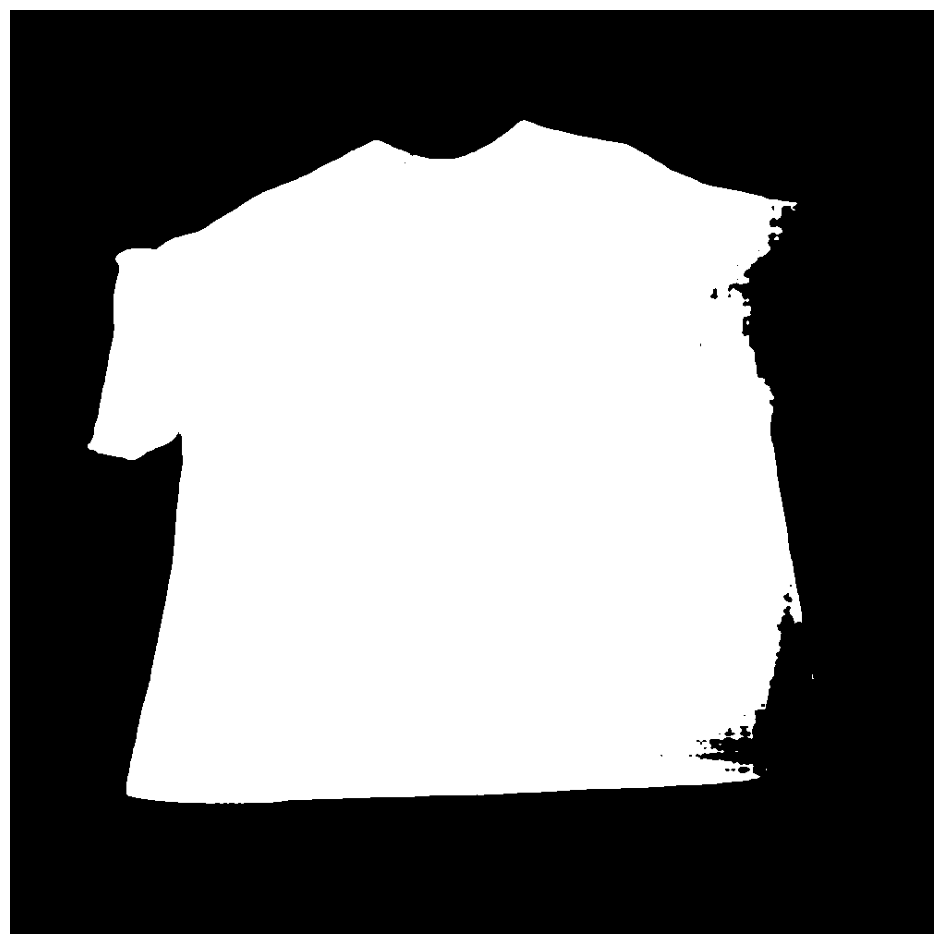

In [55]:
mask_predictor = SamPredictor(sam)

mask_predictor.set_image(image_rgb)

box = np.array(sam_result[0]['bbox'])

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

# Assuming we're interested in the mask with the highest score
best_mask_index = np.argmax(scores)
best_mask = masks[2]

mask_image = np.uint8(best_mask * 255)

# Display the mask
sv.plot_image(mask_image)